### Library Imports 

In [250]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

plt.rcParams["figure.figsize"] = (25,10)

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

In [251]:
### Read the input file
df = pd.read_csv('E:\\Embroker\\MarketData.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


- As the given data is stock market data, let's visualize it as a candle- stick pattern

In [252]:



fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()

#### Following insights can be drawn from the candle-stick chart above
- Overall the company seems to be doing pretty good, with expected major drops in prices around the economic depression of 2008-09 and when the pandemic struck in 2020
- The stock didn't really pick up before the 2008 economic crises.
- The stock has been in the bullish trend post the 2008-09 economic depression period ( the period of boom of IT- sector), so there seems to be a good chance for the stock belonging to IT sector


### Part-1) Examination of Daily Volume Data


In [256]:
df["Volume"].describe()

count    5.232000e+03
mean     3.164975e+09
std      1.516307e+09
min      3.560700e+08
25%      1.732522e+09
50%      3.270445e+09
75%      3.990660e+09
max      1.145623e+10
Name: Volume, dtype: float64

(array([ 975.,  834., 1618., 1188.,  376.,  148.,   60.,   25.,    6.,
           2.]),
 array([3.5607000e+08, 1.4660860e+09, 2.5761020e+09, 3.6861180e+09,
        4.7961340e+09, 5.9061500e+09, 7.0161660e+09, 8.1261820e+09,
        9.2361980e+09, 1.0346214e+10, 1.1456230e+10]),
 <BarContainer object of 10 artists>)

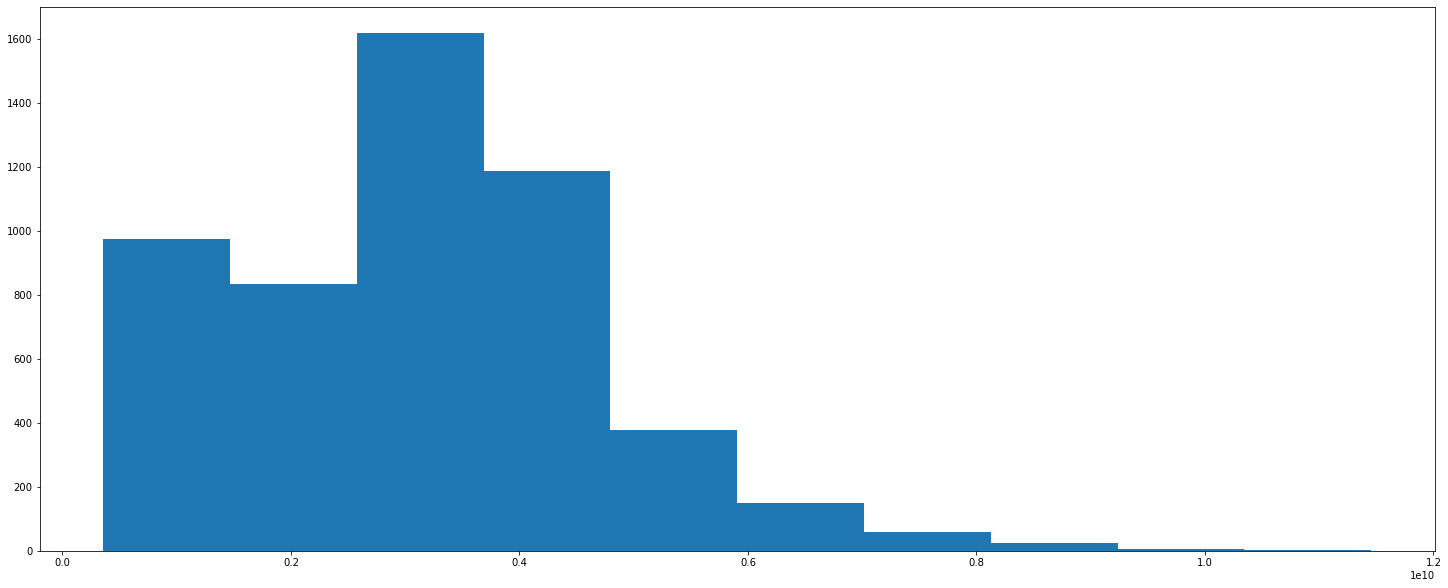

In [257]:
## Histogram plot of volume to check it's distribution
plt.hist(df["Volume"])

- Seems like the distribution is **positively skewed**, with volumes generally lying lying between 2 to 5 billion

#### Identification of number of clusters for daily volume data
- The Kmeans algorithm has been used to cluster the volume data

In [29]:
SSW = {}      ## dict to store Sum of Square within distance for different number of clusters
for num_clusters in range(2,9):  ## Fit the K means algorithm for number of clusters between 2 to 9 
    
    kmeans = KMeans(num_clusters, random_state=42) ## Random state set to particular value to make the 
                                                   ## initial random initialization of clusters deterministic
    kmeans.fit(df[["Volume"]])
    SSW[num_clusters] = kmeans.inertia_

Text(0.5, 0, 'Number of Clusters')

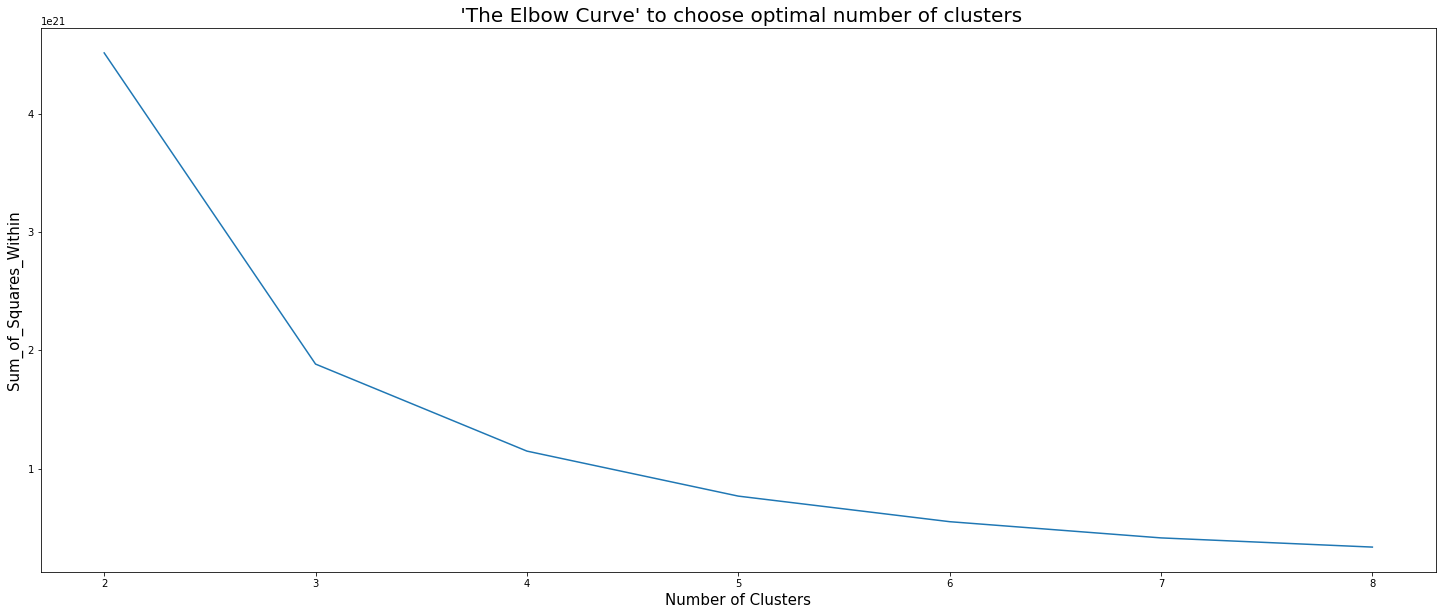

In [259]:
### Plot of the Elbow curve to determine the optimal number of clusters
ax = sns.lineplot(SSW.keys(), SSW.values())
ax.set_title(" 'The Elbow Curve' to choose optimal number of clusters", fontsize=20)
ax.set_ylabel("Sum_of_Squares_Within", fontsize = 15)
ax.set_xlabel("Number of Clusters",fontsize = 15)


- From the above elbow plot, 3 or 4 clusters seems to be the optimal choice, as the SSW drop in SSW is not very significant post 4 clusters

In [260]:
for num_clusters in [3,4]:
    kmeans = KMeans(num_clusters, random_state = 42)
    identified_clusters = kmeans.fit_predict(df[["Volume"]])
    df["volume_cluster_" + str(num_clusters)] = identified_clusters

<AxesSubplot:xlabel='Date', ylabel='Volume'>

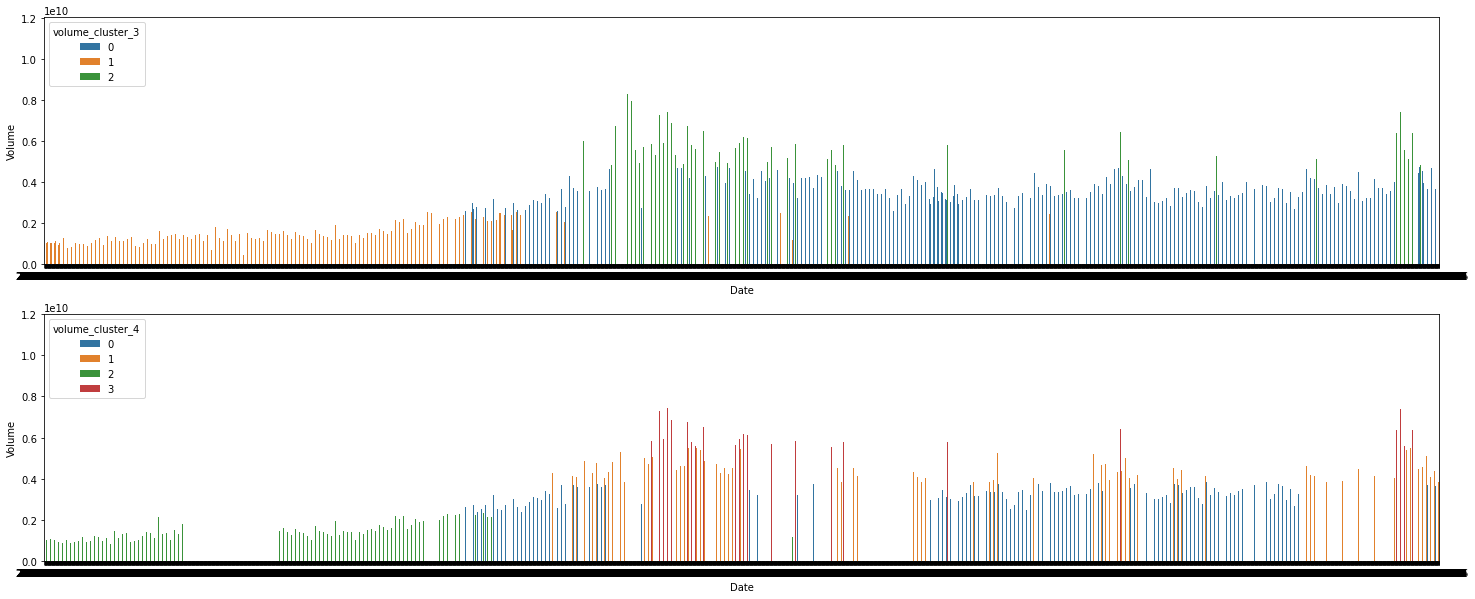

In [262]:
fig, (ax1, ax2) = plt.subplots(2,1)

sns.barplot(data =df, x = "Date", y="Volume", hue="volume_cluster_3", ax=ax1)
sns.barplot(data =df, x = "Date", y="Volume", hue="volume_cluster_4", ax=ax2)

##### From the above plot it seems like 3 clusters would make a good sense from a practical point of view.
- 01: **vol < 2 Billion** - The period before 2008 where the stock didn't really pick up.
- 02: **2 Billion <vol < 5 Billion** - The period where stock was in a healthy bullish phase.
- 03: **vol > 5 Billion** - The period where panic selling/ buying took place (during 2008 economic crises & 2020 pandemic)


### Part-2) Examination of daily open, close and volume data

#### Parameter -1 (Fractional difference between current day open and previous day open)

In [268]:
df["parameter_1"] = (df["Open"] - df["Open"].shift(1)) / df["Open"].shift(1)


- If Parameter1 <0
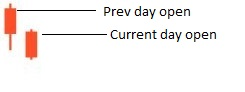


- If Parameter1 >0
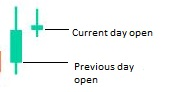

#### Parameter -2 (Fractional difference between current day open and current day close)

In [269]:
df["parameter_2"]= (df["Close"] - df["Open"] )/ df["Open"]

- If Parameter2 <0
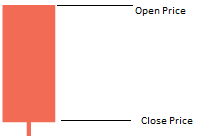

- If Parameter2 >0
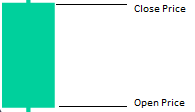

#### Parameter -3 (Fractional difference between current day volume and previous day volume)

In [270]:
df["parameter_3"] = (df["Volume"] - df["Volume"].shift(1)) / df["Volume"].shift(1)

#### Classification of the above parameters:

- The above parameters can be used to judge how the stock is performing on a daily basis:
    - **If Parameter1 >0 & Parameter2 >0** : This indicates that the stock is showing a healthy performance as it opened high  compared to previous day and closed high compared to its opening on the current day. (Parameter3 being>0 just solidifies this hypothesis)
    - **Parameter1 <0 & Parameter2 <0** : This indicates that the stock is performing poorly as it opened low compared to previous day and closed low compared to its opening on the current day. (Parameter3 being>0 just solidifies this hypothesis

### Part -3 (Modelling

In [272]:
### Extraction of day , month, year from Date
df["Date"] = pd.to_datetime(df["Date"])
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year

### Append the year and month columns to form the "month_year" column
df["month_year"] =  df["year"].astype(str)+ "-" + df["month"].astype(str).apply(lambda x: "0" + x if len(x)==1 else x) +"-01" 


In [274]:
## Group by month_year and aggregate different features
monthly_price = df.groupby(["month_year"], as_index=False).agg({"Open":"first", "Close":"last",
                                                                "High":"max", "Low":"min",
                                                               "Volume":["max","min","mean"],
                                                               "parameter_1":"mean",
                                                               "parameter_2": "mean",
                                                               "parameter_3": "mean"})


monthly_price.columns= ["month_year","month_open","month_close","month_high","month_low","vol_max","vol_min",
                      "vom_mean","param_1_mean","param_2_mean","param_3_mean"]

In [158]:
monthly_price.head(5)

,month_year,month_open,month_close,month_high,month_low,vol_max,vol_min,vom_mean,param_1_mean,param_2_mean,param_3_mean
0,2000-01-01,1469.250000,1394.459961,1478.000000,1350.140015,1225200000,931800000,1.074720e+09,-0.003939,0.002481,0.005628
1,2000-02-01,1394.459961,1366.420044,1444.550049,1325.069946,1215000000,918100000,1.045600e+09,-0.000360,0.000940,0.014418
2,2000-03-01,1366.420044,1498.579956,1552.869995,1346.619995,1482300000,901000000,1.137226e+09,0.004438,-0.004157,0.008721
3,2000-04-01,1498.579956,1452.430054,1527.189941,1339.400024,1515460000,853700000,1.058235e+09,-0.000609,0.001435,0.003019
4,2000-05-01,1452.430054,1420.599976,1481.510010,1361.089966,1152300000,722600000,9.044682e+08,-0.001218,0.000889,0.006830


#### Monthly returns (fractional difference between the month’s closing price and opening price)

In [276]:
monthly_price["monthly_returns"] = (monthly_price["month_close"] - monthly_price["month_open"]) / monthly_price["month_open"]

- **Assuming that the monthly investment made can only be withdrawn at the end of the month** , investing in a month is profitable if the monthly returns are postive  else it is negative

In [277]:
### Creation of binary variable based on whether monthly returns are more or less than 0
monthly_price["is_profitable"] = [1 if x>=0 else 0   for x in monthly_price["monthly_returns"]]

In [279]:
monthly_price.head()

,month_year,month_open,month_close,month_high,month_low,vol_max,vol_min,vom_mean,param_1_mean,param_2_mean,param_3_mean,monthly_returns,is_profitable
0,2000-01-01,1469.250000,1394.459961,1478.000000,1350.140015,1225200000,931800000,1.074720e+09,-0.003939,-0.002481,0.005628,-0.050904,0
1,2000-02-01,1394.459961,1366.420044,1444.550049,1325.069946,1215000000,918100000,1.045600e+09,-0.000360,-0.000940,0.014418,-0.020108,0
2,2000-03-01,1366.420044,1498.579956,1552.869995,1346.619995,1482300000,901000000,1.137226e+09,0.004438,0.004157,0.008721,0.096720,1
3,2000-04-01,1498.579956,1452.430054,1527.189941,1339.400024,1515460000,853700000,1.058235e+09,-0.000609,-0.001435,0.003019,-0.030796,0
4,2000-05-01,1452.430054,1420.599976,1481.510010,1361.089966,1152300000,722600000,9.044682e+08,-0.001218,-0.000889,0.006830,-0.021915,0


- Extract the rolling mean of features based on a period of 12 months

In [282]:
rolling_features = monthly_price.rolling(12, closed="left").mean()
rolling_features = rolling_features.iloc[:,:-1]

rolling_features["month_year"] = monthly_price["month_year"]
rolling_features["is_profitable"] = monthly_price["is_profitable"]
rolling_features.head(20)

,month_open,month_close,month_high,month_low,vol_max,vol_min,vom_mean,param_1_mean,param_2_mean,param_3_mean,monthly_returns,month_year,is_profitable
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-02-01,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-03-01,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-04-01,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-05-01,0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-06-01,1
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-01,0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-01,1
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-01,0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-10-01,0


In [283]:
### Check the proportions of values in the target variable " is_profitable"
rolling_features.dropna()["is_profitable"].value_counts(normalize=True)

1    0.617647
0    0.382353
Name: is_profitable, dtype: float64

- The distribution of target variable is slightly unbalanced in favour of postive class "1"

In [284]:
### Spltting data into train and validation, the last 12 months are used for validation

x_train = rolling_features.iloc[12:-12,:-2]
y_train = rolling_features.iloc[12:-12,-1]

x_test = rolling_features.iloc[-12:,:-2]
y_test = rolling_features.iloc[-12:,-1]
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

len(x_train), len(x_test)

(226, 12)

In [285]:
x_train.head()

,month_open,month_close,month_high,month_low,vol_max,vol_min,vom_mean,param_1_mean,param_2_mean,param_3_mean,monthly_returns
12,1432.143331,1419.728333,1485.666656,1354.703328,1.321613e+09,7.443083e+08,1.035665e+09,-0.000378,-0.000424,0.021331,-0.007764
13,1419.729167,1417.357503,1477.780823,1348.409993,1.397097e+09,7.544167e+08,1.056541e+09,0.000076,-0.000073,0.023073,-0.000635
14,1417.358337,1406.817495,1472.099986,1339.274160,1.409672e+09,7.623250e+08,1.064339e+09,-0.000275,-0.000415,0.021886,-0.006651
15,1406.818329,1378.629995,1448.312490,1317.154989,1.429809e+09,7.646750e+08,1.074898e+09,-0.000977,-0.000999,0.022296,-0.020061
16,1378.630829,1361.715820,1426.821665,1296.537486,1.463429e+09,7.696917e+08,1.092587e+09,-0.000546,-0.000556,0.023721,-0.011094


In [300]:
### Initialize the Decision Tree classifier
classifier = DecisionTreeClassifier(max_depth = 5, min_samples_split=5, min_samples_leaf=3, random_state=42)

In [301]:
### Fit the classifer on training set
classifier.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

In [302]:
### get the predictions on  train & test set
train_preds = classifier.predict(x_train)
test_preds = classifier.predict(x_test)

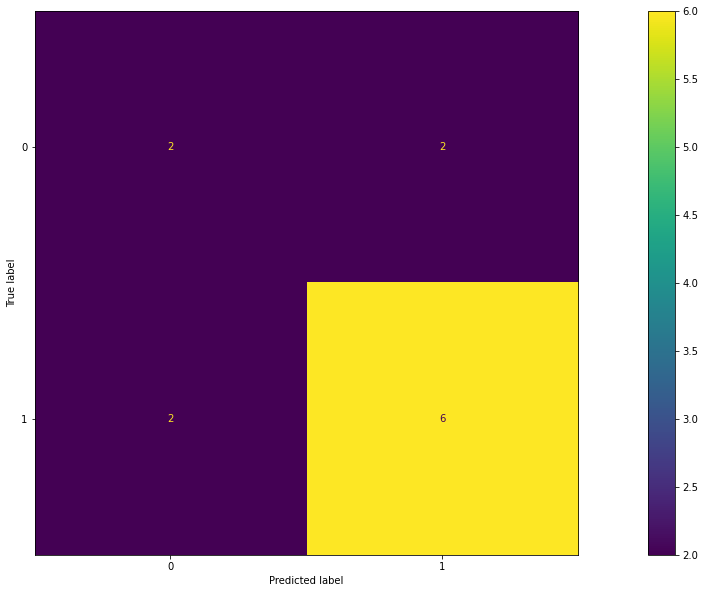

In [303]:
### Plot the confusion matrix 
cm = confusion_matrix(y_test, test_preds, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
disp.plot()
plt.show()

#### The error metric for the model -- F1 Score
- As having a decent  precision as well as  recall is  important in this problem, hence we choose f1-score as our metric

In [304]:
train_f1 = f1_score(y_train, train_preds)
test_f1 = f1_score(y_test, test_preds)

print("Train set F1 Score: ", train_f1)
print("Test set F1 Score: ", test_f1)

Train set F1 Score:  0.8143322475570033
Test set F1 Score:  0.75
